In [38]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import re

import functools
from keras import backend as K
    
import tensorflow as tf
from tensorflow.python.keras.preprocessing.sequence import pad_sequences 
from tensorflow.python.keras.preprocessing.text import Tokenizer

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Conv1D, MaxPooling1D,Flatten,GRU, Bidirectional
from keras.optimizers import Adam
from keras.initializers import Constant

from sklearn.model_selection import train_test_split

import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import gensim

In [2]:
data = pd.read_csv('data/Reviews.csv', encoding="utf-8",nrows=50000)
data = data.reindex(np.random.permutation(data.index))

In [3]:
reviews_text = data["Text"].values
reviews_rating = data["Score"].values

In [4]:
stop_words = set(stopwords.words('english'))
lemmatiser = WordNetLemmatizer()

In [5]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):  
        return 'a' # adjective
    elif pos_tag.startswith('V'): 
        return 'v' # verb
    elif pos_tag.startswith('R'):
        return 'r' # adverb
    else:           
        return 'n' # fallback to noun

In [6]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>',"",text)
    text = re.sub('[^a-z0-9 \.]', '', text)
    words = word_tokenize(text) 
    words = [w for w in words if w =="not" or not w in stop_words ]
    words_pos = pos_tag(words) 
    lemmatized_words = []
    
    for word, tag in words_pos:
        pos = get_wordnet_pos(tag)
        lemmatized_word = lemmatiser.lemmatize(word, pos=pos)
        lemmatized_words.append(lemmatized_word)
    
    text = " ".join(lemmatized_words)
    return text

In [17]:
def plot(history,loss,accuracy):
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Training', 'Validation'], loc='best')
    plt.show()

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Training', 'Validation'], loc='best')
    plt.show()

    print()
    print(f'Test loss: {loss:.3}')
    print(f'Test accuracy: {accuracy:.3}')

In [47]:
def create1(tokenizer,embedding_matrix,EMBEDDING_DIM=100):
    model = Sequential()
    embedding_layer = Embedding(len(tokenizer.word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=100,
                            trainable=False)
    
    model.add(embedding_layer)
    model.add(Dropout(0.2))
    
    model.add(LSTM(64,activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(1, activation='sigmoid'))
        
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

In [48]:
def create2(tokenizer,embedding_matrix,EMBEDDING_DIM=100):
    model = Sequential()
    embedding_layer = Embedding(len(tokenizer.word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=100,
                            trainable=False)
    
    model.add(embedding_layer)
    model.add(Dropout(0.2))
    
    model.add(LSTM(64,activation='tanh',return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(128,activation='tanh'))
    model.add(Dropout(0.2))
    
    model.add(Dense(1, activation='sigmoid'))
        
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

In [49]:
def create3(tokenizer,embedding_matrix,EMBEDDING_DIM=100):
    model = Sequential()
    embedding_layer = Embedding(len(tokenizer.word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=100,
                            trainable=False)
    
    model.add(embedding_layer)
    model.add(Dropout(0.2))
    
    model.add(LSTM(64,activation='relu',return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(128,activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(1, activation='sigmoid'))
        
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

In [50]:
def create4(tokenizer,embedding_matrix,EMBEDDING_DIM=100):
    model = Sequential()
    embedding_layer = Embedding(len(tokenizer.word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=100,
                            trainable=False)
    
    model.add(embedding_layer)
    model.add(Dropout(0.2))
    
    model.add(GRU(64,activation='relu',return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(GRU(128,activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(1, activation='sigmoid'))
        
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

In [51]:
def create5(tokenizer,embedding_matrix,EMBEDDING_DIM=100):
    model = Sequential()
    embedding_layer = Embedding(len(tokenizer.word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=100,
                            trainable=False)
    
    model.add(embedding_layer)
    model.add(Dropout(0.2))
    
    model.add(Bidirectional(LSTM(64,activation='relu',return_sequences=True)))
    model.add(Dropout(0.2))
    
    model.add(Bidirectional(LSTM(128,activation='relu')))
    model.add(Dropout(0.2))
    
    model.add(Dense(1, activation='sigmoid'))
        
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

In [19]:
def evaluate(model,x_train,y_train,x_test,y_test,batch_size=128,epochs=20):
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=.2)
    loss, accuracy  = model.evaluate(x_test, y_test, verbose=True,batch_size=batch_size)
    plot(history,loss,accuracy)

In [10]:
SIZE = reviews_text.size
reviews = []
labels = np.zeros(SIZE)

for i in range(SIZE):
    text = str(reviews_text[i])
    rating = reviews_rating[i]
    review = text
    review = preprocess_text(review)
    reviews.append(review)
    if(rating > 3.0):
        labels[i] = 1

In [11]:
x_train,x_test,y_train,y_test = train_test_split(reviews,labels,test_size=0.2,random_state=42)

In [12]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
# Fix sequence length to MAX_SEQUENCE_LENGTH. Sequences shorter than the length are
# padded and sequences longer are truncated
x_train = pad_sequences(x_train, maxlen=60, padding='post')
x_test = pad_sequences(x_test, maxlen=60, padding='post')

In [13]:
embeddings_index = {}
f = open('data/glove.6B.100d.txt', encoding = "utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

In [14]:
EMBEDDING_DIM = 100
num_words = len(tokenizer.word_index)+1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.uniform(-0.5,0.5,100)

In [15]:
def average_embedding(x_data):
    average_embedding_matrix = np.zeros((x_data.shape[0], EMBEDDING_DIM))
    for idx, embedding_vector in enumerate(x_data):
        average_embedding_vector = np.zeros((EMBEDDING_DIM, ))
        for token_index in embedding_vector:
            average_embedding_vector += embedding_matrix[token_index]
        average_embedding_vector /= len(embedding_vector)
        average_embedding_matrix[idx] = average_embedding_vector
    return average_embedding_matrix

In [16]:
x_train = average_embedding(x_train)
x_test = average_embedding(x_test)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          4592400   
_________________________________________________________________
dropout_5 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,634,705
Trainable params: 42,305
Non-trainable params: 4,592,400
_________________________________________________________________
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] 

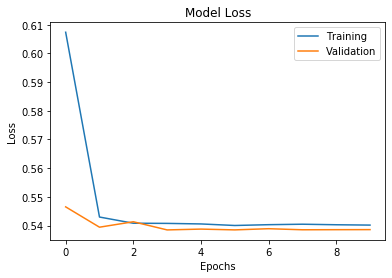

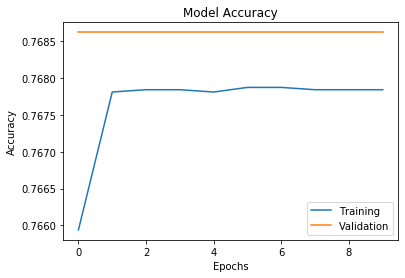


Test loss: 0.538
Test accuracy: 0.77


In [29]:
model1 = create1(tokenizer,embedding_matrix)
evaluate(model1,x_train,y_train,x_test,y_test,batch_size=128,epochs=10)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 100, 100)          4592400   
_________________________________________________________________
dropout_19 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 100, 64)           42240     
_________________________________________________________________
dropout_20 (Dropout)         (None, 100, 64)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)               

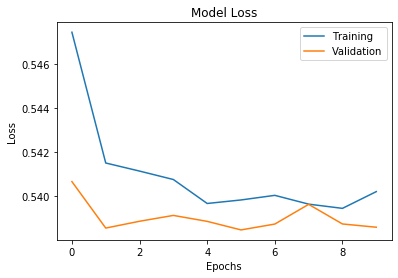

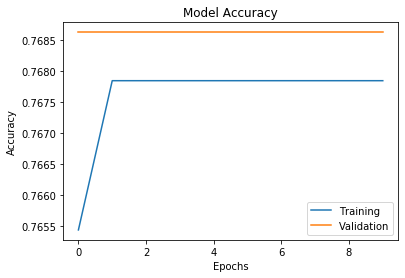


Test loss: 0.538
Test accuracy: 0.77


In [52]:
model2 = create2(tokenizer,embedding_matrix)
evaluate(model2,x_train,y_train,x_test,y_test,batch_size=128,epochs=10)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 100)          4592400   
_________________________________________________________________
dropout_22 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 100, 64)           42240     
_________________________________________________________________
dropout_23 (Dropout)         (None, 100, 64)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)               

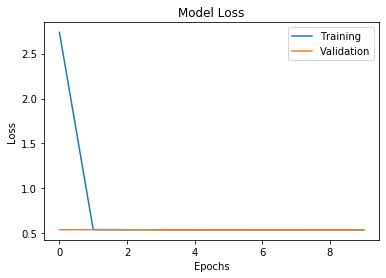

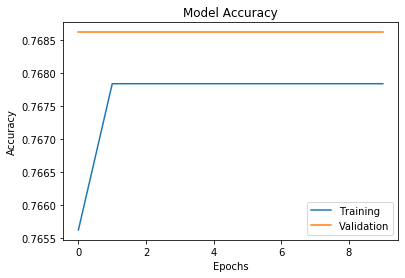


Test loss: 0.538
Test accuracy: 0.77


In [53]:
model3 = create3(tokenizer,embedding_matrix)
evaluate(model3,x_train,y_train,x_test,y_test,batch_size=128,epochs=10)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 100)          4592400   
_________________________________________________________________
dropout_25 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 100, 64)           31680     
_________________________________________________________________
dropout_26 (Dropout)         (None, 100, 64)           0         
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               74112     
_________________________________________________________________
dropout_27 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)               

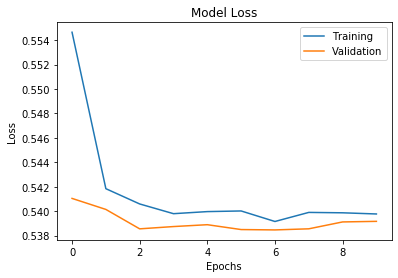

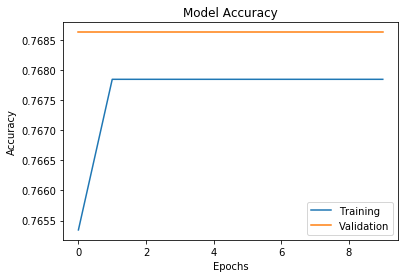


Test loss: 0.538
Test accuracy: 0.77


In [54]:
model4 = create4(tokenizer,embedding_matrix)
evaluate(model4,x_train,y_train,x_test,y_test,batch_size=128,epochs=10)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 100, 100)          4592400   
_________________________________________________________________
dropout_28 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 128)          84480     
_________________________________________________________________
dropout_29 (Dropout)         (None, 100, 128)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 256)               263168    
_________________________________________________________________
dropout_30 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)               

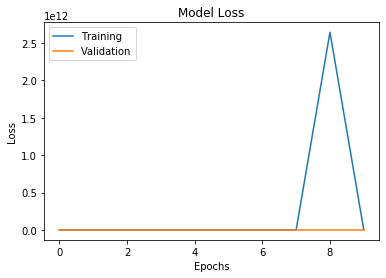

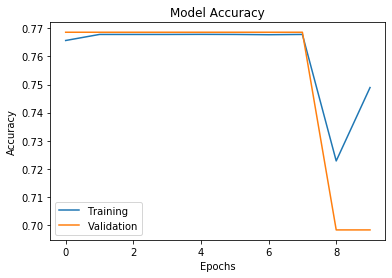


Test loss: 1.26e+02
Test accuracy: 0.695


In [55]:
model3 = create5(tokenizer,embedding_matrix)
evaluate(model3,x_train,y_train,x_test,y_test,batch_size=128,epochs=10)